# Small angle X-ray scattering data for intrinsically disordered proteins
Ellen Rieloff

[SAXS](https://en.wikipedia.org/wiki/Small-angle_X-ray_scattering) is a technique extensively used for determining *size* and *shape* of nanoparticles and macromolecules such as polymers and proteins. This notebook perform analysis of SAXS data for intrinsically disordered proteins ([IDPs](https://en.wikipedia.org/wiki/Intrinsically_disordered_proteins)): both experimental data, and theoretically calculated data from the simulation software [MOLSIM](http://www.polyelectrolytes2002.fkem1.lu.se/home.php?Program=Molsim) utilizing a coarse-grained model, and compares the both. 
The experimental data is collected for the saliva IDP Statherin. 

Load needed modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import Markdown

Initialize the work directory and move to the data folder.

In [2]:
workdir=%pwd
%cd $workdir/data

/Users/ellen/Documents/Courses/jupyter-course/project-work-erieloff/data


## Experimental data
Here we will analyze the form factor for Statherin. The SAXS data was first treated using PRIMUS in the [ATSAS package](https://www.embl-hamburg.de/biosaxs/software.html). The frames were checked for radiation damage, and averaging and buffer subtraction were performed. Also, the curve was normalized with concentration. The ATSAS package was also used for extracting the pair distance distribution function, P(r). 

The experimental data file contains the measured intensity in arbitrary units and the statistical error, for different values of the scattering vector, $q=4\pi \sin(\theta)/\lambda$, where $\theta$ is the scattering angle and $\lambda$ the wavelength. We import the data and convert $q$ from nm$^{-1}$ to Å$^{-1}$.

In [3]:
#Import experimental data
qexp, Iexp, Iexp_err = np.genfromtxt('avg_3atot.dat', unpack = True, skip_header=3, skip_footer=3)

#Convert to 1/Å
qexp = qexp/10

### Determination of Radius of gyration and I(0)
The radius of gyration is a measure of the protein size and the intensity at $q=0$ is used for determining the molecular weight.

#### Guinier analysis:

From the Guinier equation, presented below, one can obtain the radius of gyration, $R_\mathrm{g}$, and $I(0)$, the intensity extrapolated to $q=0$. 

\begin{equation}
\ln I(q) = \ln I(0) - \frac{R_\mathrm{g}^2}{3}q^2
\end{equation}

Here, $q$ is the scattering vector. The Guinier approximation is valid in the low $q$ limit, for IDPs usually $qR_\mathrm{g}<0.8$. Guinier analysis normally underestimates the $R_\mathrm{g}$ for IDPs, however, $R_\mathrm{g}$ can also be obtained from the pair distance distribution, P(r). For IDPs this is usally a more accurate method as it takes into account a larger part of the scattering curve.

The lowest $q$ data might be noisy due to the beam stop, hence we plot $I(q)$ vs $q$ in the low $q$ region to identify the lowest value that can be used in the Guinier analysis.

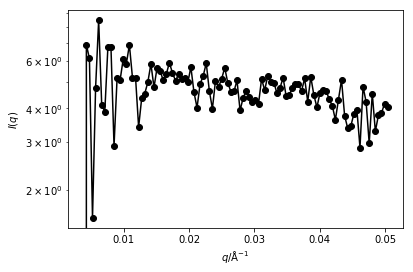

In [4]:
#Identify lowest q to use from inspection of SAXS curve
fig = plt.figure()
ax = plt.axes()
ax.plot(qexp[0:100], Iexp[0:100], marker = 'o', color = 'k')
ax.set_yscale('log')
ax.set_xlabel('$q$/Å$^{-1}$')
ax.set_ylabel('$I(q)$')
plt.show()

From the identified lowest $q$ and a starting value for maximum $q$ larger than expected for the linear region, we begin to iteratively determine $R_\mathrm{g}$ until $qR_\mathrm{g}<0.8$.

In [5]:
# Set qmin and qmax after visual inspection
qmin = 0.014 ; qmax = 0.06

deltaq = qexp[1]-qexp[0]
i_qmin = int(np.ceil((qmin-qexp[0])/deltaq)) ; i_qmax = int(np.floor((qmax-qexp[0])/deltaq))

#Perform linear regression until qRg<0.8
slope, intercept, r_value, p_value, std_err = stats.linregress(qexp[i_qmin:i_qmax]**2,np.log(Iexp[i_qmin:i_qmax]))
Rg = np.sqrt(-3*slope)
i_qmax = 300
while qexp[i_qmax]*Rg>0.8:
    slope, intercept, r_value, p_value, std_err = stats.linregress(qexp[i_qmin:i_qmax]**2,np.log(Iexp[i_qmin:i_qmax]))
    Rg = np.sqrt(-3*slope)
    i_qmax = i_qmax-1

print('Rg: %1.3f Å'%Rg)
print('Rg*q limit: %1.3f'%(Rg*qexp[i_qmax]))


Rg: 17.840 Å
Rg*q limit: 0.773


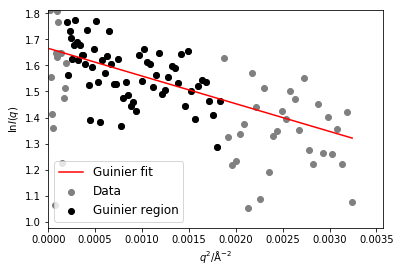

In [6]:
# Plot the Guinier fit
fig = plt.figure() ; ax = plt.axes()
ax.scatter(qexp[2:i_qmax+30]**2,np.log(Iexp[2:i_qmax+30]), color = 'grey', label = 'Data')
ax.scatter(qexp[i_qmin:i_qmax]**2,np.log(Iexp[i_qmin:i_qmax]), color = 'k', label = 'Guinier region')
ax.plot(qexp[0:i_qmax+30]**2,slope*qexp[0:i_qmax+30]**2+intercept, color = 'r', label = 'Guinier fit')
ax.axis([0, qexp[i_qmax+35]**2, np.log(Iexp[i_qmax+35]), np.log(Iexp[2])])
ax.set_ylabel('$\lnI(q)$')
ax.set_xlabel('$q^2$/Å$^{-2}$') 
ax.legend(loc='lower left',fontsize=12,frameon=True,markerfirst=True)
plt.show()

#### Pair distance distribution function:
P(r) was obtained by using the ATSAS package. The resulting $R_\mathrm{g}$ and $I(0)$ was entered in the cell below, and is presented in a table together with the values from Guinier analysis.

In [7]:
# data = [Rg from Guinier (Å), I(0) from Guinier, Rg from P(r) (Å), Rg error, I(0) from P(r), I(0) error]
data = [Rg, np.exp(intercept), 19.80, 0.57, 5.38, 0.11]
data = np.array(['{:1.2f}'.format(i) for i in data])

#Present data in a table
Markdown('''
   #### Experimental $R_g$ and I(0) determined from both Guinier analysis and P(r).
   |         |  $R_g$/Å               |      I(0)          |
   |---------|-------------------- | -------------------|
   |Guinier  | {d[0]}              |   {d[1]}           |
   |P(r)     | {d[2]} $\pm$ {d[3]} |{d[4]} $\pm$ {d[5]} |

'''.format(d=data))


   #### Experimental $R_g$ and I(0) determined from both Guinier analysis and P(r).
   |         |  $R_g$/Å               |      I(0)          |
   |---------|-------------------- | -------------------|
   |Guinier  | 17.84              |   5.29           |
   |P(r)     | 19.80 $\pm$ 0.57 |5.38 $\pm$ 0.11 |



### Molecular weight
To obtain the molecular weight, $I(0)$ needs to be converted to absolute scale. This is done by measuring the scattering of pure water.

The water data is imported and $I(0)$ for the water is determined as an average over the low $q$ region, as it is supposed to be a horizontal line.

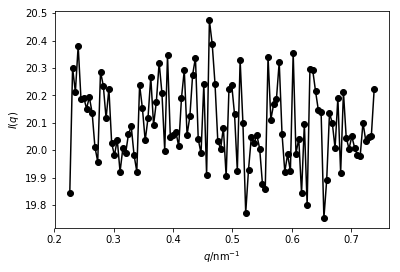

In [8]:
#Import the water data
qw, Iw, Iw_err = np.loadtxt('water_003_sub.dat', unpack = True)

#Obtain measured intensity of water
plt.plot(qw[40:150],Iw[40:150], color = 'k', marker = 'o')
I0w = np.mean(Iw[40:150])
plt.xlabel('$q$/nm$^{-1}$')
plt.ylabel('$I(q)$')
plt.show()

The molecular weight, $M_\mathrm{w}$, of the protein is determined according to:

\begin{equation}
M_\mathrm{w} = \frac{I(0) N_\mathrm{A}}{c([\rho_\mathrm{p}-\rho_\mathrm{s}]v_\mathrm{p})^2}
\end{equation}

where $N_\mathrm{A}$ is Avogadro's constant, $c$ is the protein concentration, and  $\rho_\mathrm{p}$ and $\rho_\mathrm{s}$ the scattering length density of protein and solution, respectively. $v_\mathrm{p}$ is the protein specific volume and I(0) is expresssed in cm$^{-1}$, meaning it is converted from arbitrary units by multiplication with the absolute scattering of water at the measuring temperature, divided by the water scattering in arbitrary units determined above.

In [9]:
#Constants and variables in the molecular weight calculation
I0 = float(data[4]) # Intensity at q=0 for the protein in rel. units
vp = 0.71757 # specific volume of protein (cm3/g)
des = 9.455e10 #solvent electron density (/cm2)
c = 1e-3 # protein concentration (mg/mL)
Iwabs = 1.632E-02 #absolute scattering of water at 293 K (/cm)
SLe = 2.818e-13 #scattering length of an electron (cm)
nep = 3.1994e23 #number of electrons per mass dry protein (/g) 
nes = des/SLe #number of electrons per volume solvent (/cm3)

#Calculate the molecular weight
Mw = I0/I0w*Iwabs*6.022e23/(c*((nep/vp-nes)*SLe*vp)**2)/1000
print('The molecular weight is %1.3f kDa'%Mw)

The molecular weight is 5.285 kDa


## Simulated data
Coarse-grained Monte Carlo simulations have been performed in MOLSIM. A routine therein calculates the partial structure factors and the result is found in the file with extension listsim. To obtain the total scattering intensity normalization is required. The following section imports the partial structure factors and performs normalization.

In [10]:
def normSF(filename, N):
    """ Normalizes calculated scattering data from MOLSIM.
    Input: 
    - listsim-file
    - array with number of particles of each type
    Return:
    - qsim (q vector)
    - Isim (Normalized scattering intensity)"""
    
    SF= {}
    SFerr = {}

    # Find where in the file structure factor is located and how many lines the file contains.
    length=0
    start = 0
    with open (filename, 'rt') as in_file:        # open file for reading text
        for linenum, line in enumerate(in_file):    # Keep track of line numbers
            length = length+1
            if line.lower().find("structure factor") != -1: #If case-insensitive substring search matches, then:
                start = linenum
            if linenum == start +1: #read the number of partial structure factors
                nvar = int(line)
            if linenum == start + 3: # read the number of bins in each structure factor
                nbin = int(line)
            
    #Import the partial structure factors into arrays in a dictionary
    begin = start+4
    end = length-(start+nbin+4)
    for i in range(nvar):
        qsim, SF["S{0}".format(i)], SFerr["S{0}".format(i)] = np.genfromtxt(filename, unpack = True, skip_header=begin,skip_footer=end)
        begin = begin + nbin + 2
        end = end - nbin - 2

    #Normalization to obtain the total scattering intensity.
    Ntot = sum(N)
    Ntypes =(sum(range(len(N)+1)))

    Product = np.zeros(nvar)
    place = 0
    for i in range(len(N)):
        for j in range(i,len(N)):
            if i==j:
                Product[place] = N[i]/Ntot
                place = place + 1
            else:
                Product[place] = np.sqrt(N[i]*N[j])/Ntot*2
                place = place +1
    
    Isim = 0
    for i in range(place):
        Isim = Isim + SF['S{0}'.format(i)]*Product[i]
    Isim = Isim/Ntot

    return(qsim,Isim)

To use the function above to normalize the scattering intensity, we need to specify the number of particles of the different particle types in the simulated chain. For comparison with experimental data we also specify the ensemble average of $R_\mathrm{g}$ from simulation.

In [11]:
# The number of particles of each type. Write 0 for counterions if they are included.
N = np.array([5, 5, 2, 33])

# Ensemble average of the radius of gyration
# Rgsim = [ensemble average of Rg (Å), precision]
Rgsim = [18.00, 0.02]

#Normalize the calculated scattering curve
qsim, Isim = normSF('statherin.listsim', N)

### Comparison of experimental and simulated data
Plotting the data as $I(q)$ vs $q$ on a logarithmic scale gives a clear description of the form factor. For IDPs the curve is smooth with no minima, due to smearing from the large conformational ensemble. 

To characterize the shape of the protein a Kratky plot is used. The dimensionless Kratky plot is obtained as follows: $(qR_\mathrm{g})^2I(q)/I(0)$ vs $qR_\mathrm{g}$. For an intrinsically disordered protein it should rise and reach a plateau with an upwards slope.

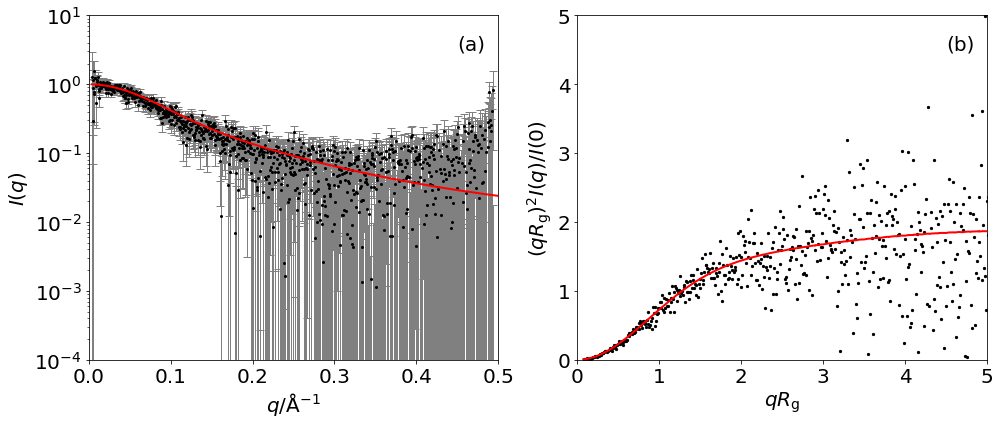

In [12]:
#Plot the scattering curve from experiment and simulation in one figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
ax1.errorbar(qexp, Iexp/float(data[4]), Iexp_err/float(data[4]), lw=0, marker='o', ms=2, elinewidth=1.,capsize=4, color = 'k', ecolor = 'gray',zorder = 1)
ax1.plot(qsim, Isim, lw=2, color = 'r')
ax1.set_yscale('log')
ax1.set_xlabel('$q$/Å$^{-1}$',fontsize = 20)
ax1.set_ylabel('$I(q)$')
ax1.axis([0, 0.5, 1e-4, 10])
ax1.annotate('(a)',(0.9,0.9),xycoords='axes fraction',fontsize=20)

ax2.scatter(qexp*float(data[2]),Iexp/float(data[4])*(qexp*float(data[2]))**2, 5, color = 'k')
ax2.plot(qsim*float(Rgsim[0]),Isim*(qsim*Rgsim[0])**2, lw=2, color = 'r')
ax2.set_xlabel('$qR_\mathrm{g}$')
ax2.set_ylabel('$(qR_\mathrm{g})^2I(q)/I(0)$')
ax2.axis([0, 5, 0, 5])
ax2.annotate('(b)',(0.9,0.9),xycoords='axes fraction',fontsize=20)

for i,ax in enumerate(f.axes):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                  ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
f.tight_layout()

#plt.savefig('figure1.png',dpi=600)
plt.show()

The data from experiment and simulation agrees well both with respect to the form factor and the shape, as shown by the Kratky plot. Below we compare the radius of gyration determined from simulation and experiment.

In [13]:
#Print the Rg from experiment and simulation
Markdown('''
$R_\mathrm g$ from experiment: {0} $\pm$ {1} Å \n
$R_\mathrm g$ from simulation: {2} $\pm$ {3} Å
'''.format(data[2],data[3], Rgsim[0], Rgsim[1]))


$R_\mathrm g$ from experiment: 19.80 $\pm$ 0.57 Å 

$R_\mathrm g$ from simulation: 18.0 $\pm$ 0.02 Å


## Compare stiffness of different IDPs
In this section we load simulated data for three different proteins and create a dimensionless Kratky plot, to compare the stiffness in these proteins at 150 mM salt. 

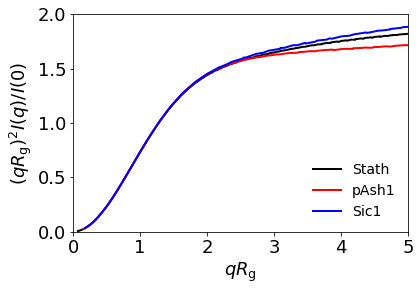

In [14]:
# The number of particles of each type.
Nstath = np.array([5, 5, 2, 33])
Npash = np.array([2, 17, 56, 10, 0, 0])
Nsic = np.array([1, 14, 73, 6, 0, 0])

# Ensemble average of the radius of gyration
# Rg and error (Å) in order Stath, pAsh and Sic
Rgs = [18.22, 0.05, 25.61, 0.08, 29.01, 0.06]

#Normalize the calculated scattering curve
qstath, Istath = normSF('differentIDPs/stath1.listsim', Nstath)
qpash, Ipash = normSF('differentIDPs/pash1.listsim', Npash)
qsic, Isic = normSF('differentIDPs/sic1.listsim', Nsic)

fig = plt.figure() ; ax = plt.axes()
ax.plot(qstath*Rgs[0],Istath*(qstath*Rgs[0])**2, 5, lw=2, color = 'k', label = 'Stath')
ax.plot(qpash*Rgs[2],Ipash*(qpash*Rgs[2])**2, 5, lw=2, color = 'r', label = 'pAsh1')
ax.plot(qsic*Rgs[4],Isic*(qsic*Rgs[4])**2, 5, lw=2, color = 'b', label = 'Sic1')
ax.set_xlabel('$qR_\mathrm{g}$')
ax.set_ylabel('$(qR_\mathrm{g})^2I(q)/I(0)$')
ax.set_yticks(np.arange(0,2.1,0.5))
ax.axis([0, 5, 0, 2])
ax.legend(loc='lower right',fontsize=14,frameon=False,markerfirst=True)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
    
plt.show()

In the model used for simulating the proteins, the proteins differ only by length and charge distribution. At 150 mM salt most electrostatic interactions are screened out, and hence the difference between the proteins is quite small.